# Code Templates: LSTM Prediction Model
2024-2 SWCON314

In [62]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from torch.utils.data import DataLoader, TensorDataset, ConcatDataset

import glob
from tqdm import tqdm

from LSTMModel import LSTMModel

In [63]:
# Hyperparameters
TIME_STEP = 10
STRIDE = 2
INPUT_SIZE = 24
OUTPUT_SIZE = 1
BATCH_SIZE = 64
HIDDEN_LAYER_SIZE = 128
EPOCHS = 200
LEARNING_RATE = 0.001

# path and filename to save trained model
OUTPUT_FILENAME = 'model/free_1.pth'

# path to dataset
DATA_PATH = 'data'

# selecting columns from dataset csv file
x_features = [i for i in range(24)]
y_features = [48]

csv_file_paths = glob.glob(f'{DATA_PATH}/**/*.csv', recursive=True)
for path in csv_file_paths:
    print(path)

cuda_available = torch.cuda.is_available()
print(cuda_available)

data\free\free1\2_rear.csv
data\free\free1\4_rear.csv
data\free\free1\6_rear.csv
data\free\free2\2_rear.csv
data\free\free2\4_rear.csv
data\free\free3\2_rear.csv
data\free\free3\4_rear.csv
data\free\free3\6_rear.csv
data\free\free4\2_rear.csv
data\free\free4\4_rear.csv
data\free\free4\6_rear.csv
data\free\free5\2_rear.csv
data\free\free5\4_rear.csv
data\free\free5\6_rear.csv
data\free\free6\12.csv
data\free\free6\4.csv
data\free\free6\8.csv
data\free\free7\1.csv
data\free\free7\4.csv
data\free\free7\8.csv
data\free\free8\10.csv
data\free\free8\4.csv
data\free\free8\8.csv
data\free\free9\12.csv
data\free\free9\4.csv
data\free\free9\8.csv
False


In [64]:
def preprocess_file(file_path,  time_steps):
    data = pd.read_csv(file_path)
    X_features = data.values[:, x_features]
    y_target = data.values[:, y_features]
    X, y = create_dataset(X_features, y_target, time_steps)
    return X, y

def create_dataset(X, y, time_steps, stride=STRIDE):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, stride):  # i의 증가량을 stride로 조정 -> sequence에서 시작 index를 stride 숫자씩 옮겨가며 시작 index ~ index + time_step만큼의 열을 추출
        v = X[i:(i + time_steps)]   # input feature data sequence
        Xs.append(v)
        ys.append(y[i + time_steps])

    return np.array(Xs), np.array(ys)

def load_and_process_data(file_paths, time_steps, batch_size=16):
    all_X, all_y = [], []
    
    for file_path in file_paths:
        # 파일별 데이터 처리
        X, y = preprocess_file(file_path, time_steps)
        all_X.append(X)
        all_y.append(y)
    
    # 모든 데이터를 하나로 합침
    combined_X = np.concatenate(all_X, axis=0)
    combined_y = np.concatenate(all_y, axis=0)
    
    # 데이터 분할
    X_train, X_val, y_train, y_val = train_test_split(
        combined_X, combined_y, test_size=0.1, random_state=42)
    
    # DataLoader 생성
    train_loader = DataLoader(TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32)),
        batch_size=batch_size,
        shuffle=True)
    val_loader = DataLoader(TensorDataset(
        torch.tensor(X_val, dtype=torch.float32),
        torch.tensor(y_val, dtype=torch.float32)),
        batch_size=batch_size,
        shuffle=False)
    
    return train_loader, val_loader

def create_final_loaders(csv_file_paths, time_steps, batch_size):
    # csv_file_paths 분할
    subsets = [csv_file_paths[x:x+100] for x in range(0, len(csv_file_paths), 100)]

    # 각 서브셋에 대한 DataLoader 리스트 초기화
    train_loaders = []
    valid_loaders = []

    # 각 서브셋에 대해 DataLoader 생성 및 리스트에 추가
    for subset in subsets:
        train_loader, valid_loader = load_and_process_data(
            subset,
            time_steps=time_steps,
            batch_size=batch_size)
        train_loaders.append(train_loader)
        valid_loaders.append(valid_loader)

    # DataLoader들을 합친 최종 DataLoader 생성
    final_train_loader = DataLoader(ConcatDataset(
        [loader.dataset for loader in train_loaders]),
        batch_size=batch_size,
        shuffle=True)
    final_valid_loader = DataLoader(ConcatDataset(
        [loader.dataset for loader in valid_loaders]),
        batch_size=batch_size,
        shuffle=False)

    return final_train_loader, final_valid_loader

trainloader, validloader = create_final_loaders(
    csv_file_paths, time_steps=TIME_STEP, batch_size=BATCH_SIZE)

In [71]:
criterion_mse = nn.MSELoss()  # Mean Squared Error
criterion_mae = nn.L1Loss()  # Mean Absolute Error
criterion_huber = nn.SmoothL1Loss()  # Huber Loss

# 선택적으로 사용할 손실 함수 지정 ("mse", "mae", "huber")
loss_function = "huber" 

if loss_function == "mse":
    criterion = criterion_mse
elif loss_function == "mae":
    criterion = criterion_mae
elif loss_function == "huber":
    criterion = criterion_huber
else:
    raise ValueError("Invalid loss function selected. Choose 'mse', 'mae', or 'huber'.")

model = LSTMModel(input_size=INPUT_SIZE, hidden_layer_size=HIDDEN_LAYER_SIZE, output_size=OUTPUT_SIZE)

if cuda_available:
    model.cuda()

epochs = EPOCHS
best_val_rmse = float('inf')
early_stopping_patience = 10
patience_counter = 0

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in tqdm(trainloader, desc=f"Epoch {epoch + 1}/{epochs} Training"):
        if cuda_available:
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch) 
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        train_loss += loss.item()

    validation_frequency = 5
    if epoch % validation_frequency == 0 or epoch == epochs - 1:
        model.eval()
        val_rmse = []
        y_preds, y_actuals = [], []

        with torch.no_grad():
            for X_batch, y_batch in tqdm(validloader, desc=f"Epoch {epoch + 1}/{epochs} Validation"):
                if cuda_available:
                    X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

                y_pred = model(X_batch)
                rmse = torch.sqrt(criterion_mse(y_pred, y_batch)).cpu().item()  
                val_rmse.append(rmse)

                if len(y_preds) == 0:
                    y_preds = y_pred.cpu().numpy()
                    y_actuals = y_batch.cpu().numpy()
                else:
                    y_preds = np.vstack((y_preds, y_pred.cpu().numpy()))
                    y_actuals = np.vstack((y_actuals, y_batch.cpu().numpy()))

        epoch_val_rmse = np.mean(val_rmse)
        print(f"Epoch {epoch + 1}, Validation RMSE: {epoch_val_rmse}")

        scheduler.step(epoch_val_rmse) 

        if epoch_val_rmse < best_val_rmse:
            best_val_rmse = epoch_val_rmse
            patience_counter = 0
            print(f"New best model with RMSE: {best_val_rmse}, saving model...")
            torch.save(model.state_dict(), OUTPUT_FILENAME)
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch + 1} with best RMSE: {best_val_rmse}")
            break


Epoch 1/200 Validation: 100%|██████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 253.01it/s]


Epoch 1, Validation RMSE: 0.003844215026633306
New best model with RMSE: 0.003844215026633306, saving model...


Epoch 6/200 Validation: 100%|██████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 261.21it/s]


Epoch 6, Validation RMSE: 0.0029741866288311553
New best model with RMSE: 0.0029741866288311553, saving model...


Epoch 11/200 Validation: 100%|█████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 251.31it/s]


Epoch 11, Validation RMSE: 0.0029464761768891053
New best model with RMSE: 0.0029464761768891053, saving model...


Epoch 16/200 Validation: 100%|█████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 261.91it/s]


Epoch 16, Validation RMSE: 0.0027153353263257127
New best model with RMSE: 0.0027153353263257127, saving model...


Epoch 21/200 Validation: 100%|█████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 239.37it/s]


Epoch 21, Validation RMSE: 0.002687618573845336
New best model with RMSE: 0.002687618573845336, saving model...


Epoch 26/200 Validation: 100%|█████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 226.21it/s]


Epoch 26, Validation RMSE: 0.0027185583938703394


Epoch 31/200 Validation: 100%|█████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 236.89it/s]


Epoch 31, Validation RMSE: 0.002607962370596149
New best model with RMSE: 0.002607962370596149, saving model...


Epoch 36/200 Validation: 100%|█████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 233.96it/s]


Epoch 36, Validation RMSE: 0.002488393752807469
New best model with RMSE: 0.002488393752807469, saving model...


Epoch 41/200 Validation: 100%|█████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 255.12it/s]


Epoch 41, Validation RMSE: 0.0025019698606973343


Epoch 46/200 Validation: 100%|█████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 238.81it/s]


Epoch 46, Validation RMSE: 0.002584392437711358


Epoch 51/200 Validation: 100%|█████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 241.95it/s]


Epoch 51, Validation RMSE: 0.0025868306684335976


Epoch 56/200 Validation: 100%|█████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 257.14it/s]


Epoch 56, Validation RMSE: 0.0022278328489681535
New best model with RMSE: 0.0022278328489681535, saving model...


Epoch 61/200 Validation: 100%|█████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 256.14it/s]


Epoch 61, Validation RMSE: 0.0021927410800179296
New best model with RMSE: 0.0021927410800179296, saving model...


Epoch 66/200 Validation: 100%|█████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 253.94it/s]


Epoch 66, Validation RMSE: 0.002227817139955181


Epoch 71/200 Validation: 100%|█████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 241.98it/s]


Epoch 71, Validation RMSE: 0.00214118112555959
New best model with RMSE: 0.00214118112555959, saving model...


Epoch 76/200 Validation: 100%|█████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 246.36it/s]


Epoch 76, Validation RMSE: 0.0021424439531101875


Epoch 81/200 Validation: 100%|█████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 213.91it/s]


Epoch 81, Validation RMSE: 0.0020891214177633324
New best model with RMSE: 0.0020891214177633324, saving model...


Epoch 86/200 Validation: 100%|█████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 209.69it/s]


Epoch 86, Validation RMSE: 0.0019784101362650595
New best model with RMSE: 0.0019784101362650595, saving model...


Epoch 91/200 Validation: 100%|█████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 233.42it/s]


Epoch 91, Validation RMSE: 0.0019287836744986248
New best model with RMSE: 0.0019287836744986248, saving model...


Epoch 96/200 Validation: 100%|█████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 249.82it/s]


Epoch 96, Validation RMSE: 0.0019407099126979258


Epoch 101/200 Validation: 100%|████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 252.48it/s]


Epoch 101, Validation RMSE: 0.0018756102636512933
New best model with RMSE: 0.0018756102636512933, saving model...


Epoch 106/200 Validation: 100%|████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 242.91it/s]


Epoch 106, Validation RMSE: 0.0018370621449624498
New best model with RMSE: 0.0018370621449624498, saving model...


Epoch 111/200 Validation: 100%|████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 217.33it/s]


Epoch 111, Validation RMSE: 0.0020180668604249754


Epoch 116/200 Validation: 100%|████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 232.46it/s]


Epoch 116, Validation RMSE: 0.0018032807327637618
New best model with RMSE: 0.0018032807327637618, saving model...


Epoch 121/200 Validation: 100%|████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 241.06it/s]


Epoch 121, Validation RMSE: 0.0019571873585157323


Epoch 126/200 Validation: 100%|████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 240.79it/s]


Epoch 126, Validation RMSE: 0.0019312373567090342


Epoch 131/200 Validation: 100%|████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 234.33it/s]


Epoch 131, Validation RMSE: 0.001771488555029712
New best model with RMSE: 0.001771488555029712, saving model...


Epoch 136/200 Validation: 100%|████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 246.00it/s]


Epoch 136, Validation RMSE: 0.0018734108713088613


Epoch 141/200 Validation: 100%|████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 236.79it/s]


Epoch 141, Validation RMSE: 0.0017468316699237082
New best model with RMSE: 0.0017468316699237082, saving model...


Epoch 146/200 Validation: 100%|████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 203.55it/s]


Epoch 146, Validation RMSE: 0.0018651876774983425


Epoch 151/200 Validation: 100%|████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 242.69it/s]


Epoch 151, Validation RMSE: 0.0018018524225970561


Epoch 156/200 Validation: 100%|████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 261.53it/s]


Epoch 156, Validation RMSE: 0.001754820576135182


Epoch 161/200 Validation: 100%|████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 254.57it/s]


Epoch 161, Validation RMSE: 0.0017904258001539292


Epoch 166/200 Validation: 100%|████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 258.97it/s]


Epoch 166, Validation RMSE: 0.0017524535598402674


Epoch 171/200 Validation: 100%|████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 254.10it/s]


Epoch 171, Validation RMSE: 0.0017523858696222305


Epoch 176/200 Validation: 100%|████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 261.06it/s]


Epoch 176, Validation RMSE: 0.0017689789969925628


Epoch 181/200 Validation: 100%|████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 240.82it/s]


Epoch 181, Validation RMSE: 0.001784922417507253


Epoch 186/200 Validation: 100%|████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 243.70it/s]


Epoch 186, Validation RMSE: 0.0017564570721746845


Epoch 191/200 Validation: 100%|████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 223.54it/s]

Epoch 191, Validation RMSE: 0.0017859018725258384
Early stopping at epoch 191 with best RMSE: 0.0017468316699237082


100%|█████████████████████████████████████████████████████████████████████████████████| 1208/1208 [00:00<00:00, 1316.30it/s]

RMSE avg: 0.005028092651690528


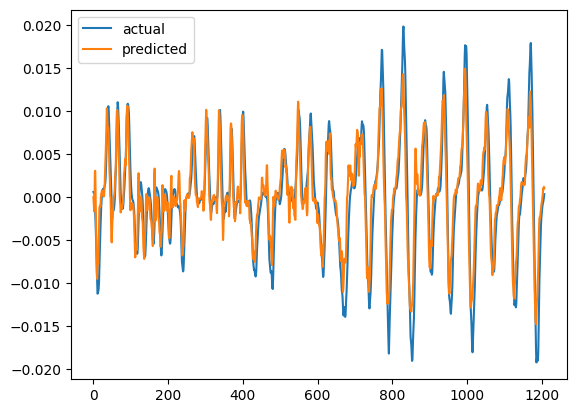

In [72]:
import matplotlib.pyplot as plt

model.eval()
data = pd.read_csv(r'data/free/free1/4_rear.csv') # choice was arbitrary selection from the dataset 

X = data.values[:,x_features].astype(np.float32)
y = data.values[:,y_features].astype(np.float32)
y_pred = []

error_sum = 0
with torch.no_grad():
    for i in tqdm(range(X.shape[0]-5)):
        t = torch.Tensor(X[i:i+5])
        t = t.unsqueeze(0)

        ## if you have GPU
        if cuda_available:
            t = t.cuda()
        
        pred = model(t)
        pred = pred.cpu()
        pred = pred.squeeze().cpu()
        y_pred.append(pred.numpy())
        rmse = np.sqrt(np.sum((y[i] - pred.numpy()) ** 2) / y[i].size)
        error_sum += rmse

error_sum = error_sum / (X.shape[0]-5)
print(f'RMSE avg: {error_sum}')

plt.plot(y[5:], label='actual')
y_pred_arr = np.array(y_pred)
plt.plot(y_pred_arr, label='predicted')
plt.legend(loc='best')
plt.show(block=True)